<a href="https://colab.research.google.com/github/kishanAk21/Restricted_Boltzmann_Machine_for_Reco_Sys/blob/main/main_tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Statement¶
Aim of this exercise is to get initial insights of the online purchase dataset and recommend related products to user based on similar other users. 

We would be using Restricted Boltzmann Machines (RBMs) algorithm for developing recommender system model. The process for developing recommender system using RBMs is highlighed here.

- Data Cleaning and Pre-processing: Initially we would clean and pre-process the dataset to make it ready for model training purpose.
- Model Functions: We would develop a few functions that would be useful in model training.
- Model Training: This step includes training the model with batches. It includes updating weights, hidden bias and visible bias parameters.
- Model testing: We would select one test case to illustrate model's performance on it. 


You can learn the basic theory behind RBMs here. https://en.wikipedia.org/wiki/Restricted_Boltzmann_machine

You can check out this practical guide on training RBMs here. https://www.cs.toronto.edu/~hinton/absps/guideTR.pdf


In [120]:
# Dependencies

import tensorflow as tf

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [121]:
# Mouting Gdrive for data

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [122]:
# Reading Dataset from Gdrive

data = pd.read_csv('/content/drive/MyDrive/sample30.csv')
data.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,I read through the reviews on here before look...,Disappointed,NaN,NaN,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,walker557,Negative


Here we only need columns 'name' --> Product Name, 'reviews_username' --> User Name, and 'reviews_rating' --> Rating. We would drop other columns as they would not add any value to our model.

In [123]:
# Redefining ratings data
ratings = data[['name', 'reviews_username', 'reviews_rating']]

# dropping rows with null entires in 'reviews_username' column
ratings = ratings.dropna(axis=0,
                        subset = ['reviews_username'])

ratings.head()

,name,reviews_username,reviews_rating
0,Pink Friday: Roman Reloaded Re-Up (w/dvd),joshua,5
1,Lundberg Organic Cinnamon Toast Rice Cakes,dorothy w,5
2,Lundberg Organic Cinnamon Toast Rice Cakes,dorothy w,5
3,K-Y Love Sensuality Pleasure Gel,rebecca,1
4,K-Y Love Sensuality Pleasure Gel,walker557,1


There might be some duplucate data entry as well. We would make sure to avoid them as they can create data duplication and overfitting problems.

In [124]:
# dropping duplicate rows (except first entry)

ratings.drop_duplicates(inplace=True)
ratings.shape

(27739, 3)

In [125]:
# Keep last in case of multiple ratings by a user for the same product

ratings.drop_duplicates(subset = ['name', 'reviews_username'], keep='last', inplace=True)
ratings.head()

,name,reviews_username,reviews_rating
0,Pink Friday: Roman Reloaded Re-Up (w/dvd),joshua,5
1,Lundberg Organic Cinnamon Toast Rice Cakes,dorothy w,5
3,K-Y Love Sensuality Pleasure Gel,rebecca,1
4,K-Y Love Sensuality Pleasure Gel,walker557,1
5,K-Y Love Sensuality Pleasure Gel,samantha,1


In [126]:
ratings.shape

(27588, 3)

Label encoding helps converting string based data into numeric entries.

In [127]:
# label_encoder1
label_encoder1 = preprocessing.LabelEncoder()
 
# Encode labels in column 'species'.
ratings['reviews_username'] = label_encoder1.fit_transform(ratings['reviews_username'])


# label_encoder2
label_encoder2 = preprocessing.LabelEncoder()
 
# Encode labels in column 'species'.
ratings['name'] = label_encoder2.fit_transform(ratings['name'])


ratings.head()

,name,reviews_username,reviews_rating
0,182,11440,5
1,140,6974,5
3,120,19327,1
4,120,24205,1
5,120,20202,1


In [128]:
# Defining User-Product dataframe

user_rating_df = ratings.pivot(index='reviews_username', columns='name', values='reviews_rating')
user_rating_df.head()

name,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Here, we want to convert the explicit ratings into implicit for better learning by RBM algorithm. We woud map null, 1s and 2s to 0 and 3s, 4s, and 5s to 1. This basicaly means a product is liked by a user only if rating provided is 3 or above.

In [129]:
# Normalizing dataframe
user_rating_df = user_rating_df/user_rating_df.max().max() # rating pre-processing method-1
norm_user_rating_df = user_rating_df.fillna(0)
# norm_user_rating_df = norm_user_rating_df.replace({1:0, 2:0, 3:1, 4:1, 5:1}) # rating pre-processing method-2

trainingset, testset = train_test_split(norm_user_rating_df, train_size=0.75, random_state=2021)
print(len(trainingset), len(testset))


trX = trainingset.values
trX[0:5]


trX_test = testset.values
trX_test[0:5]

18685 6229


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [130]:
# Defining hidden layer bias, visible layer bias and weights

hiddenUnits = 64
visibleUnits =  len(user_rating_df.columns)

vb = tf.Variable(tf.zeros([visibleUnits]), tf.float32) # visible layer bias
hb = tf.Variable(tf.zeros([hiddenUnits]), tf.float32) # hidden layer bias

weight_initer = tf.initializers.RandomNormal(stddev=0.01)
W = tf.Variable(weight_initer(shape=(visibleUnits, hiddenUnits)))

In [131]:
# Printing W (weight array)

W

<tf.Variable 'Variable:0' shape=(271, 64) dtype=float32, numpy=
array([[-0.01855492, -0.0079542 , -0.00687993, ..., -0.0026382 ,
         0.00868687,  0.0055113 ],
       [ 0.01315728,  0.01906698, -0.0062426 , ...,  0.00572285,
        -0.00316302,  0.00111578],
       [-0.00619044,  0.00507565,  0.00957664, ...,  0.00290526,
         0.00960816, -0.00459931],
       ...,
       [-0.01244725,  0.01008775, -0.00396763, ...,  0.00869648,
        -0.00393524, -0.01180317],
       [-0.00210178,  0.0073568 ,  0.01343394, ..., -0.01195249,
        -0.00148707, -0.01120171],
       [-0.00572317, -0.00651307,  0.00086954, ...,  0.00232784,
         0.00568841, -0.01128506]], dtype=float32)>

Let's define functions to be used while model training process. 

In [132]:
# defining a function to return generated hidden states 
def hidden_layer(v0_state, W, hb):
    h0_prob = tf.reshape(tf.nn.sigmoid(tf.matmul(v0_state, W) + hb), [-1,hiddenUnits]) 
    h0_state = tf.nn.relu(tf.sign(h0_prob - tf.random.uniform(tf.shape(h0_prob)))) 
    return h0_prob, h0_state

# Defining function to return recalculated visible states 
def reconstructed_output(h0_state, W, vb):
    v1_prob = tf.nn.sigmoid(tf.matmul(h0_state, tf.transpose(W)) + vb) 
    v1_state = tf.nn.relu(tf.sign(v1_prob - tf.random.uniform(tf.shape(v1_prob)))) 
    return v1_prob, v1_state

# Defining function for RMSE
def error(v0_state, v1_state):
    return tf.math.reduce_mean(tf.math.sqrt(tf.reduce_mean(tf.square(v0_state - v1_state))))

epoch: 1 Train reconstruction error: 0.117723346 validation reconstruction error: 0.11613443
epoch: 2 Train reconstruction error: 0.102290615 validation reconstruction error: 0.0979422
epoch: 3 Train reconstruction error: 0.08882879 validation reconstruction error: 0.09138452
epoch: 4 Train reconstruction error: 0.09138623 validation reconstruction error: 0.08805946
epoch: 5 Train reconstruction error: 0.086499535 validation reconstruction error: 0.08646616
epoch: 6 Train reconstruction error: 0.082424216 validation reconstruction error: 0.08466822
epoch: 7 Train reconstruction error: 0.08440009 validation reconstruction error: 0.08395858
epoch: 8 Train reconstruction error: 0.085259765 validation reconstruction error: 0.08312538
epoch: 9 Train reconstruction error: 0.08484821 validation reconstruction error: 0.08234565
epoch: 10 Train reconstruction error: 0.08253032 validation reconstruction error: 0.0819013
epoch: 11 Train reconstruction error: 0.08328677 validation reconstruction e

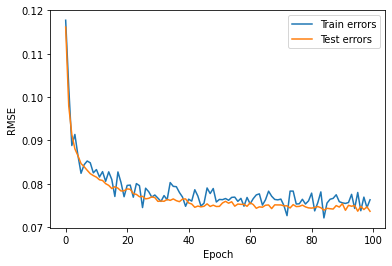

In [133]:
# Training hyper-parameters
epochs = 100
batchsize = 256
errors = []
errors_test = []
weights = []
alpha = 0.001
cd_loops = 1

# creating datasets
train_ds = tf.data.Dataset.from_tensor_slices((np.float32(trX))).batch(batchsize)

# Model Training
for epoch in range(epochs):
    for batch_x in train_ds:
        v0_state = batch_x
        v1_state = batch_x
        _, v0_prob= hidden_layer(v0_state, W, hb)

        for i in range(cd_loops):
          _, h1_state = hidden_layer(v1_state, W, hb)
          _, v1_state = reconstructed_output(h1_state, W, vb)

          

        v1_prob, _ = hidden_layer(v1_state, W, hb)

        delta_W = tf.matmul(tf.transpose(v0_state), v0_prob) - tf.matmul(tf.transpose(v1_state), v1_prob)
        W = W + alpha * delta_W

        vb = vb + alpha * tf.reduce_mean(v0_state - v1_state, 0)
        hb = hb + alpha * tf.reduce_mean(v0_prob - v1_prob, 0) 


        err_train = error(v0_state, v1_state)

    # Train 
    errors.append(err_train.numpy())
    
    # Validation (testset)
    inputUser = tf.convert_to_tensor(trX_test,"float32")
    inputUser1 = inputUser

    _, h1_state = hidden_layer(inputUser1, W, hb)
    _, inputUser1 = reconstructed_output(h1_state, W, vb)

    err_test = error(inputUser, inputUser1)
    errors_test.append(err_test.numpy())

    print ('epoch:', epoch+1, 'Train reconstruction error:', err_train.numpy(), 'validation reconstruction error:', err_test.numpy())
    

plt.plot(errors)
plt.plot(errors_test)
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.legend(["Train errors", "Test errors"], loc ="upper right")
plt.show()

Now we would check the model performance on one of the test (validation) case.

In [134]:
# Test user case

mock_user_id = 201

In [135]:
# Selecting the input user

inputUser = tf.convert_to_tensor(testset[testset.index == mock_user_id].values,"float32")
v0 = inputUser

In [136]:
# Feeding in the user and reconstructing the input

_, hh0 = hidden_layer(v0, W, hb)
vv1, _ = reconstructed_output(hh0, W, vb)
rec = vv1

In [137]:
scored_movies_df_mock = pd.DataFrame(list(zip(user_rating_df.columns, list(rec[0].numpy()))), columns=['name', 'proba'])
scored_movies_df_mock.sort_values('proba', ascending=False).head(20)

,name,proba
93,93,0.060878
64,64,0.052714
129,129,0.026799
65,65,0.025880
41,41,0.024192
239,239,0.019517
200,200,0.015447
183,183,0.013865
171,171,0.011871
151,151,0.008581


In [138]:
prod_df_mock = ratings[ratings['reviews_username'] == mock_user_id]
prod_df_mock

,name,reviews_username,reviews_rating
87,171,201,3


In [139]:
# Merging prod_df_mock with ratings_df by 'name'

merged_df_mock = scored_movies_df_mock.merge(prod_df_mock, on ='name', how='outer')

In [140]:
merged_df_mock['product_name'] = label_encoder2.inverse_transform(merged_df_mock['name'])
merged_df_mock.sort_values('proba', ascending=False).head(10)

,name,proba,reviews_username,reviews_rating,product_name
93,93,0.060878,NaN,NaN,Godzilla 3d Includes Digital Copy Ultraviolet ...
64,64,0.052714,NaN,NaN,Clorox Disinfecting Bathroom Cleaner
129,129,0.026799,NaN,NaN,L'or233al Paris Elvive Extraordinary Clay Reba...
65,65,0.025880,NaN,NaN,Clorox Disinfecting Wipes Value Pack Scented 1...
41,41,0.024192,NaN,NaN,"Burt's Bees Lip Shimmer, Raisin"
239,239,0.019517,NaN,NaN,The Resident Evil Collection 5 Discs (blu-Ray)
200,200,0.015447,NaN,NaN,Red (special Edition) (dvdvideo)
183,183,0.013865,NaN,NaN,Planes: Fire Rescue (2 Discs) (includes Digita...
171,171,0.011871,201.0,3.0,Olay Regenerist Deep Hydration Regenerating Cream
151,151,0.008581,NaN,NaN,Mike Dave Need Wedding Dates (dvd + Digital)


It can be observed that,
- User '201' has already purchased item '171'. Item '171' is having higher probability value as per our model, which is a good sign.
- Apart from item '171', other items can be recommended to user '201' as per our model.

-------------